# Loading Data from drive

In [ ]:
from google.colab import drive
drive.mount("./drive")

Mounted at ./drive


# Importing Modules

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.metrics import *

from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import *
from keras import backend as K

from imutils import build_montages
import os
from PIL import Image
import cv2
from collections import Counter
import imutils
from imutils import paths
from tqdm import tqdm, notebook

from scipy import *
import scipy
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns

from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import plotly as ply

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
ply.offline.init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

!echo "Importing all Modules"

Importing all Modules


In [ ]:
from zipfile import ZipFile
with ZipFile("/content/drive/MyDrive/Face_dataset_ML.zip") as file:
    file.extractall()
file.close()

with ZipFile("/content/drive/MyDrive/Siamese_Network_only_faces_AayAjiAraAshKomRpd.zip") as file:
    file.extractall()
file.close()

with ZipFile("/content/drive/MyDrive/MobileNetWeights.zip") as file:
    file.extractall()
file.close()

with ZipFile("/content/drive/MyDrive/VAE_AyuAjiAraAshKomRpd.zip") as file:
    file.extractall()
file.close()

In [ ]:
!mv ./content ./SiameseNet_Weights
!mv ./ModelCheckpoints ./VAE

# Loading Models

In [ ]:
# Face models
encoder = load_model("./VAE/VAE_encoder.h5")
decoder = load_model("./VAE/VAE_decoder.h5")

siameseNet = load_model("./SiameseNet_Weights/Siamese_Network_only_faces_AayAjiAraAshKomRpd.h5")


# face_effnetb7 = load_model("/content/drive/MyDrive/Weights/EfficientNetB7_Pretrained_weights_Only_Faces.h5")
# face_mobnet = load_model("/content/drive/MyDrive/Weights/MobielNet_Pretrained_weights_Only_Faces.h5")
# face_resNet50 = load_model("/content/drive/MyDrive/Weights/Resnet50_Pretrained_weights_Only_Faces.h5")
# face_vgg16 = load_model("/content/drive/MyDrive/Weights/VGG16_Pretrained_weights_Only_Faces.h5")
# face_vgg19 = load_model("/content/drive/MyDrive/Weights/VGG19_Pretrained_weights_Only_Faces.h5")


# GAIT MODELS
cus_vgg16_0 = load_model("/content/drive/MyDrive/VGG16_Gait_half_pretrained/vgg16_0.h5")
cus_vgg16_54 = load_model("/content/drive/MyDrive/VGG16_Gait_half_pretrained/vgg16_54.h5")
cus_vgg16_90 = load_model("/content/drive/MyDrive/VGG16_Gait_half_pretrained/vgg16_90.h5")

cus_resnet50_0 = load_model("/content/drive/MyDrive/ResNet50_Gait_fromScratch/resNet50_0.h5")
cus_resnet50_54 = load_model("/content/drive/MyDrive/ResNet50_Gait_fromScratch/resNet50_54.h5")
cus_resnet50_90 = load_model("/content/drive/MyDrive/ResNet50_Gait_fromScratch/resNet50_90.h5")

cus_vgg16_0 = Model(inputs = cus_vgg16_0.input, outputs = cus_vgg16_0.layers[-2].output)
cus_vgg16_54 = Model(inputs = cus_vgg16_54.input, outputs = cus_vgg16_54.layers[-2].output)
cus_vgg16_90 = Model(inputs = cus_vgg16_90.input, outputs = cus_vgg16_90.layers[-2].output)

cus_resnet50_0 = Model(inputs = cus_resnet50_0.input, outputs = cus_resnet50_0.layers[-2].output)
cus_resnet50_54 = Model(inputs = cus_resnet50_54.input, outputs = cus_resnet50_54.layers[-2].output)
cus_resnet50_90 = Model(inputs = cus_resnet50_90.input, outputs = cus_resnet50_90.layers[-2].output)

mobnet_0 = load_model("./MobileNetWeights/mobile_0.h5")
mobnet_54 = load_model("./MobileNetWeights/mobile_54.h5")
mobnet_90 = load_model("./MobileNetWeights/mobile_90.h5")

!echo "All Models are Successfully Loaded"

All Models are Successfully Loaded


# Building Siamese Model

In [ ]:
rpd_base_img = cv2.imread("/content/Face_dataset/train/Rudra/img_20.jpg")
aayush_base_img = cv2.imread("/content/Face_dataset/train/Aayush/210.jpg")
komal_base_img = cv2.imread("/content/Face_dataset/train/Komal/img_151.jpg")
ashish_base_img = cv2.imread("/content/Face_dataset/train/Ashish/img1_32.jpg")
ajita_base_img = cv2.imread("/content/Face_dataset/train/Ajita/img_26.jpg")
aradhana_base_img = cv2.imread("/content/Face_dataset/train/Aradhana/img_13.jpg")

base_imgs = [rpd_base_img, aayush_base_img, komal_base_img, ashish_base_img, ajita_base_img, aradhana_base_img]
labels = ["RUDRA", "AAYUSH", "KOMAL", "ASHISH", "AJITA", "ARADHANA"]

In [ ]:
cus_resnet50_0.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_16[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
class Siamese_Model(Model):
    def __init__(self, base_imgs, labels):
        super(Siamese_Model, self).__init__()
        self.base_imgs = base_imgs
        self.labels = labels
        self.IMG_SHAPE = [100, 100, 3]
        self.build_model()
        self.base_imgs = list(map(lambda x : self.preprocess_img(x), self.base_imgs))
    
    
    def preprocess_img(self, img):
        # print((self.IMG_SHAPE[1], self.IMG_SHAPE[0]))
        # print(img)
        img = cv2.resize(img, (self.IMG_SHAPE[1], self.IMG_SHAPE[0]), interpolation = cv2.INTER_NEAREST)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img
    
    def make_pairs(self, img, base_imgs):
        pairs = []
        img = self.preprocess_img(img)  
        for base_img in base_imgs:
            pairs.append([base_img, img])
        return (np.array(pairs))

    def show_base_imgs(self):
        plt.figure(figsize = (20, 15))
        for i in range(len(self.base_imgs)):
            plt.subplot(1, len(self.base_imgs), i+1)
            curImage = self.base_imgs[i]
            # curImage = self.preprocess_img(curImage)
            plt.title(self.labels[i])
            plt.imshow(curImage)
            plt.axis('off')
        plt.show();

    def build_model(self):
        self.siameseNet = load_model("./SiameseNet_Weights/Siamese_Network_only_faces_AayAjiAraAshKomRpd.h5")
        print(self.siameseNet.summary())        
        return self.siameseNet

    def predict(self, img):
        proba = []
        self.pairs = self.make_pairs(img, self.base_imgs)
        for i in range(len(self.base_imgs)):
            pred = self.siameseNet.predict([np.array([self.pairs[i, 0]]), np.array([self.pairs[i, 1]])])[0][0]
            proba.append(pred)
        sum_proba = sum(proba)
        proba_score = list(map(lambda x: x/sum_proba, proba))
        proba_score = np.array(proba_score, dtype = 'float')
        return proba_score
    
    def predict_classes(self, img):
        class_name = self.labels[np.argmax(self.predict(img))]
        return class_name


    def __str__(self):
        return "____SIAMESE NETWORK____"       


In [ ]:
siamese_Net = Siamese_Model(base_imgs, labels)

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
model_1 (Functional)            (None, 128)          25600       input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
Euclidean_distance (Lambda)     (None, 1)            0           model_1[0][0]       

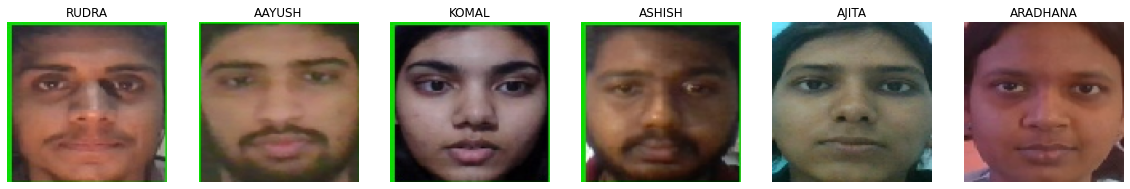

In [ ]:
siamese_Net.show_base_imgs()

In [ ]:
gei_data = "/content/drive/MyDrive/GEI_Ashish/GaitDataset"
paths = {}

for i in range(0, 198, 18):
  paths[f'gei_{i}'] = gei_data + "/" + '0'*(3-len(str(i))) + str(i)

paths

{'gei_0': '/content/drive/MyDrive/GEI_Ashish/GaitDataset/000',
 'gei_108': '/content/drive/MyDrive/GEI_Ashish/GaitDataset/108',
 'gei_126': '/content/drive/MyDrive/GEI_Ashish/GaitDataset/126',
 'gei_144': '/content/drive/MyDrive/GEI_Ashish/GaitDataset/144',
 'gei_162': '/content/drive/MyDrive/GEI_Ashish/GaitDataset/162',
 'gei_18': '/content/drive/MyDrive/GEI_Ashish/GaitDataset/018',
 'gei_180': '/content/drive/MyDrive/GEI_Ashish/GaitDataset/180',
 'gei_36': '/content/drive/MyDrive/GEI_Ashish/GaitDataset/036',
 'gei_54': '/content/drive/MyDrive/GEI_Ashish/GaitDataset/054',
 'gei_72': '/content/drive/MyDrive/GEI_Ashish/GaitDataset/072',
 'gei_90': '/content/drive/MyDrive/GEI_Ashish/GaitDataset/090'}

In [ ]:
os.listdir(paths["gei_0"]+'//'+'train')

['001', '003', '005', '002', '004', '006']

# Preparing DataFrame

{

'Aayush':'001',
'Ajita':'002',
'Aradhana':'003',
'Ashish':'004',
'Komal':'005',
'Rudra':'006'

}

In [ ]:
train_features_label = {'trainface':[],
                  '0_deg':[],
                  '54_deg':[],
                  '90_deg':[],
                  'label':[]
                  }

val_features_label = {'valface':[],
                  '0_deg':[],
                  '54_deg':[],
                  '90_deg':[],
                  'label':[]
                  }

test_features_label = {'testface':[],
                  '0_deg':[],
                  '54_deg':[],
                  '90_deg':[],
                  'label':[]
                  }
                  
angles = [0, 54, 90]
for angle in angles:
    angle_count = 0
    labels = []
    print(f"==============Doing for angle {angle}==============")
    for class_ in range(1,7):
        img_dir = os.listdir(os.path.join(paths[f'gei_{angle}'], 'train', f'00{class_}'))
        print(f"Inside 00{class_} folder")
        i = 0
        for img in img_dir:
            i+=1
            curImg = cv2.imread(os.path.join(paths[f'gei_{angle}'], 'train', f'00{class_}', img))
            curImg = cv2.cvtColor(curImg, cv2.COLOR_BGR2RGB)
            curImg = cv2.resize(curImg, (224, 224))
            train_features_label[f'{angle}_deg'].append(curImg)
            
            if (len(train_features_label['label']) < 180):
                train_features_label['label'].append(class_)  
            if (i==30):
                break

        print(f"Collected {i} images")
    angle_count += 1

==============Doing for angle 0==============
Inside 001 folder
Collected 30 images
Inside 002 folder
Collected 30 images
Inside 003 folder
Collected 30 images
Inside 004 folder
Collected 30 images
Inside 005 folder
Collected 30 images
Inside 006 folder
Collected 30 images
==============Doing for angle 54==============
Inside 001 folder
Collected 30 images
Inside 002 folder
Collected 30 images
Inside 003 folder
Collected 30 images
Inside 004 folder
Collected 30 images
Inside 005 folder
Collected 30 images
Inside 006 folder
Collected 30 images
==============Doing for angle 90==============
Inside 001 folder
Collected 30 images
Inside 002 folder
Collected 30 images
Inside 003 folder
Collected 30 images
Inside 004 folder
Collected 30 images
Inside 005 folder
Collected 30 images
Inside 006 folder
Collected 30 images


In [ ]:
angles = [0, 54, 90]
for angle in angles:
    angle_count = 0
    labels = []
    print(f"==============Doing for angle {angle}==============")
    for class_ in range(1,7):
        img_dir = os.listdir(os.path.join(paths[f'gei_{angle}'], 'val', f'00{class_}'))
        print(f"Inside 00{class_} folder")
        i = 0
        for img in img_dir:
            i+=1
            curImg = cv2.imread(os.path.join(paths[f'gei_{angle}'], 'val', f'00{class_}', img))
            curImg = cv2.cvtColor(curImg, cv2.COLOR_BGR2RGB)
            curImg = cv2.resize(curImg, (224, 224))
            val_features_label[f'{angle}_deg'].append(curImg)
            test_features_label[f'{angle}_deg'].append(curImg)
            
            if (len(val_features_label['label']) < 60):
              val_features_label['label'].append(class_)  
              test_features_label['label'].append(class_)

            if (i==10):
                break

        print(f"Collected {i} images")
    angle_count += 1

==============Doing for angle 0==============
Inside 001 folder
Collected 10 images
Inside 002 folder
Collected 10 images
Inside 003 folder
Collected 10 images
Inside 004 folder
Collected 10 images
Inside 005 folder
Collected 10 images
Inside 006 folder
Collected 10 images
==============Doing for angle 54==============
Inside 001 folder
Collected 10 images
Inside 002 folder
Collected 10 images
Inside 003 folder
Collected 10 images
Inside 004 folder
Collected 10 images
Inside 005 folder
Collected 10 images
Inside 006 folder
Collected 10 images
==============Doing for angle 90==============
Inside 001 folder
Collected 10 images
Inside 002 folder
Collected 10 images
Inside 003 folder
Collected 10 images
Inside 004 folder
Collected 10 images
Inside 005 folder
Collected 10 images
Inside 006 folder
Collected 10 images


In [ ]:
Counter(test_features_label['label'])

Counter({1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10})

In [ ]:
len(train_features_label['label'])

180

In [ ]:
train_path = "./Face_dataset//train"
test_path = "./Face_dataset//test"
val_path = "./Face_dataset//val"

print("============================ Inside Training folder ============================")
for class_ in sorted(os.listdir(train_path)):
    img_count = 0
    for img in os.listdir(os.path.join(train_path, class_)):
        img_count += 1
        curImg = cv2.imread(os.path.join(train_path, class_, img))
        curImg  = cv2.cvtColor(curImg, cv2.COLOR_BGR2RGB)
        curImg = cv2.resize(curImg, (100, 100))
        train_features_label['trainface'].append(curImg)
    print(f"Collected {img_count} images from {class_} folder")

print()

print("============================ Inside Validation folder ============================")
for class_ in sorted(os.listdir(val_path)):
    img_count = 0
    for img in os.listdir(os.path.join(val_path, class_)):
        img_count += 1
        curImg = cv2.imread(os.path.join(val_path, class_, img))
        curImg  = cv2.cvtColor(curImg, cv2.COLOR_BGR2RGB)
        curImg = cv2.resize(curImg, (100, 100))
        val_features_label['valface'].append(curImg)
    print(f"Collected {img_count} images from {class_} folder")

print()

print("============================ Inside Testing folder ============================")
for class_ in sorted(os.listdir(test_path)):
    img_count = 0
    for img in os.listdir(os.path.join(test_path, class_)):
        img_count += 1
        curImg = cv2.imread(os.path.join(test_path, class_, img))
        curImg  = cv2.cvtColor(curImg, cv2.COLOR_BGR2RGB)
        curImg = cv2.resize(curImg, (100, 100))
        test_features_label['testface'].append(curImg)
    print(f"Collected {img_count} images from {class_} folder")


============================ Inside Training folder ============================
Collected 30 images from Aayush folder
Collected 30 images from Ajita folder
Collected 30 images from Aradhana folder
Collected 30 images from Ashish folder
Collected 30 images from Komal folder
Collected 30 images from Rudra folder

============================ Inside Validation folder ============================
Collected 10 images from Aayush folder
Collected 10 images from Ajita folder
Collected 10 images from Aradhana folder
Collected 10 images from Ashish folder
Collected 10 images from Komal folder
Collected 10 images from Rudra folder

============================ Inside Testing folder ============================
Collected 10 images from Aayush folder
Collected 10 images from Ajita folder
Collected 10 images from Aradhana folder
Collected 10 images from Ashish folder
Collected 10 images from Komal folder
Collected 10 images from Rudra folder


In [ ]:
train_data = pd.DataFrame(train_features_label)
val_data = pd.DataFrame(val_features_label)
test_data = pd.DataFrame(test_features_label)

In [ ]:
train_data['label'] = train_data['label'].apply(lambda x : x-1)
val_data['label'] = val_data['label'].apply(lambda x : x-1)
test_data['label'] = test_data['label'].apply(lambda x: x-1)

In [ ]:
train_data.sample(3)

,trainface,0_deg,54_deg,90_deg,label
17,"[[[13, 218, 6], [33, 204, 22], [32, 201, 28], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0
70,"[[[144, 96, 112], [100, 56, 71], [79, 39, 54],...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",2
78,"[[[146, 98, 114], [97, 52, 67], [75, 35, 49], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",2


In [ ]:
val_data.sample(3)

,valface,0_deg,54_deg,90_deg,label
8,"[[[11, 219, 4], [31, 204, 22], [35, 204, 30], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0
26,"[[[178, 101, 107], [178, 107, 112], [139, 79, ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",2
12,"[[[113, 241, 251], [115, 242, 253], [118, 241,...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",1


In [ ]:
test_data.sample(3)

,testface,0_deg,54_deg,90_deg,label
51,"[[[39, 24, 27], [40, 25, 28], [44, 26, 30], [5...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",5
46,"[[[9, 220, 0], [13, 217, 8], [16, 213, 15], [1...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",4
16,"[[[123, 241, 253], [122, 235, 246], [121, 225,...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",1


In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   testface  60 non-null     object
 1   0_deg     60 non-null     object
 2   54_deg    60 non-null     object
 3   90_deg    60 non-null     object
 4   label     60 non-null     int64 
dtypes: int64(1), object(4)
memory usage: 2.5+ KB


In [ ]:
val_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   valface  60 non-null     object
 1   0_deg    60 non-null     object
 2   54_deg   60 non-null     object
 3   90_deg   60 non-null     object
 4   label    60 non-null     int64 
dtypes: int64(1), object(4)
memory usage: 2.5+ KB


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   trainface  180 non-null    object
 1   0_deg      180 non-null    object
 2   54_deg     180 non-null    object
 3   90_deg     180 non-null    object
 4   label      180 non-null    int64 
dtypes: int64(1), object(4)
memory usage: 7.2+ KB


In [ ]:
class_enc = {0:'Aayush', 1:'Ajita', 2:'Aradhana', 3:'Ashish', 4:'Komal', 5:'Rudra'}
train_data["class_name"] = train_data['label'].apply(lambda x: class_enc[x])
val_data["class_name"] = val_data['label'].apply(lambda x: class_enc[x])
test_data['class_name'] = test_data['label'].apply(lambda x : class_enc[x])

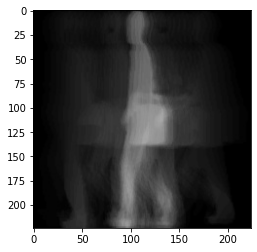

In [ ]:
plt.imshow(test_data["90_deg"][0])

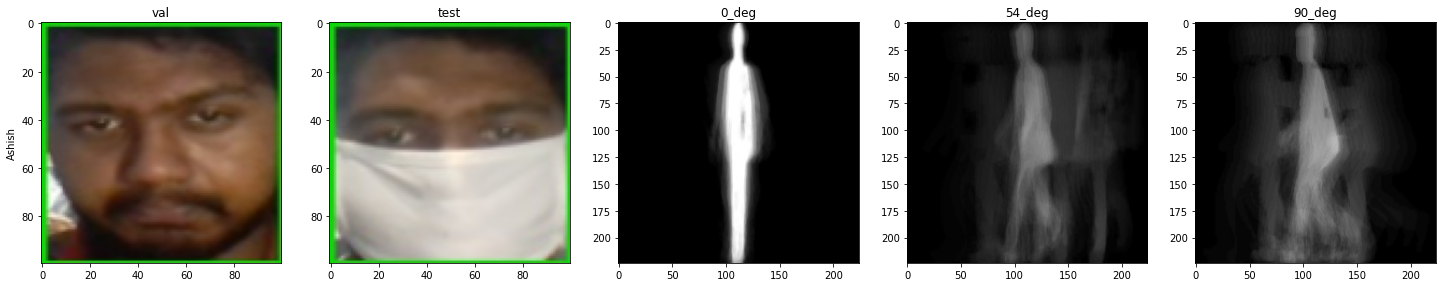

In [ ]:
num = np.random.randint(len(val_data))
plt.figure(figsize = (25, 12))
plt.subplot(1, 5, 1)
plt.ylabel(val_data['class_name'][num])
plt.title('val')
plt.imshow(val_data['valface'][num])
plt.subplot(1, 5, 2)
plt.title(test_data['class_name'][num])
plt.title('test')
plt.imshow(test_data['testface'][num])
plt.subplot(1, 5, 3)
plt.title(test_data['class_name'][num])
plt.title('0_deg')
plt.imshow(test_data['0_deg'][num])
plt.subplot(1, 5, 4)
plt.title(test_data['class_name'][num])
plt.title('54_deg')
plt.imshow(test_data['54_deg'][num])
plt.subplot(1, 5, 5)
plt.title(test_data['class_name'][num])
plt.title('90_deg')
plt.imshow(test_data['90_deg'][num])

plt.show();

# Saving the data inside Drive

In [ ]:
if not os.path.exists(".//drive//MyDrive//FaceGeiCombo_0_54_90"):
    os.mkdir(".//drive//MyDrive//FaceGeiCombo_0_54_90")
    train_data.to_csv(".//drive//MyDrive//FaceGeiCombo_0_54_90//train_gei_combo.csv", index=False)
    val_data.to_csv(".//drive//MyDrive//FaceGeiCombo_0_54_90//val_gei_combo.csv", index=False)
    test_data.to_csv(".//drive//MyDrive//FaceGeiCombo_0_54_90//test_gei_combo.csv", index = False)

In [ ]:
!ls -lh .//drive//MyDrive//FaceGeiCombo_0_54_90

total 555K
-rw------- 1 root root 111K Feb 22 15:19 test_gei_combo.csv
-rw------- 1 root root 333K Feb 22 15:19 train_gei_combo.csv
-rw------- 1 root root 111K Feb 22 15:19 val_gei_combo.csv


# Fusion Approaches

## 1. NN models as feature extractors

In [ ]:
train_vgg16_0_vecs = []; val_vgg16_0_vecs = []; test_vgg16_0_vecs = []
train_resnet50_0_vecs = []; val_resnet50_0_vecs = []; test_resnet50_0_vecs = []
train_vgg16Pretrained_0_vecs = []; val_vgg16Pretrained_0_vecs = []; test_vgg16Pretrained_0_vecs = []
train_resnet50Pretrained_0_vecs = []; val_resnet50Pretrained_0_vecs = []; test_resnet50Pretrained_0_vecs = [] 

train_vgg16_54_vecs = []; val_vgg16_54_vecs = []; test_vgg16_54_vecs = []
train_resnet50_54_vecs = []; val_resnet50_54_vecs = []; test_resnet50_54_vecs = []
train_vgg16Pretrained_54_vecs = []; val_vgg16Pretrained_54_vecs = []; test_vgg16Pretrained_54_vecs = []
train_resnet50Pretrained_54_vecs = []; val_resnet50Pretrained_54_vecs = []; test_resnet50Pretrained_54_vecs = [] 

train_vgg16_90_vecs = []; val_vgg16_90_vecs = []; test_vgg16_90_vecs = []
train_resnet50_90_vecs = []; val_resnet50_90_vecs = []; test_resnet50_90_vecs = []
train_vgg16Pretrained_90_vecs = []; val_vgg16Pretrained_90_vecs = []; test_vgg16Pretrained_90_vecs = []
train_resnet50Pretrained_90_vecs = []; val_resnet50Pretrained_90_vecs = []; test_resnet50Pretrained_90_vecs = [] 

In [ ]:
test_data.shape

(60, 6)

In [ ]:
train_data.shape

(180, 6)

In [ ]:
val_data.shape

(60, 6)

In [ ]:
# Using encoder to get the face emeddings
trainface_encoder_vecs = []; valface_encoder_vecs = []; testface_encoder_vecs = []

for face in tqdm(train_features_label['trainface']):
  fc = cv2.resize(face, (128, 128))
  fc = np.array([fc])
  _, _, z = encoder.predict(fc)
  trainface_encoder_vecs.append(z[0])

for face in tqdm(val_features_label['valface']):
  fc = cv2.resize(face, (128, 128))
  fc = np.array([fc])
  _, _, z = encoder.predict(fc)
  valface_encoder_vecs.append(z[0])

for face in tqdm(list(test_features_label['testface'])):
  fc = cv2.resize(face, (128, 128))
  fc = np.array([fc])
  _, _, z = encoder.predict(fc)
  testface_encoder_vecs.append(z[0])
  

100%|██████████| 60/60 [00:01<00:00, 31.81it/s]


In [ ]:
# Using resnet50 (trained from scratch) as feat extractor

# train
for img in tqdm(list(train_features_label['0_deg'])):
  gei_img = np.array([img])
  feat = cus_resnet50_0.predict(gei_img)
  train_resnet50_0_vecs.append(feat[0])

for img in tqdm(list(train_features_label['54_deg'])):
  gei_img = np.array([img])
  feat = cus_resnet50_54.predict(gei_img)
  train_resnet50_54_vecs.append(feat[0])

for img in tqdm(list(train_features_label['90_deg'])):
  gei_img = np.array([img])
  feat = cus_resnet50_90.predict(gei_img)
  train_resnet50_90_vecs.append(feat[0])  

# val & test
for img in tqdm(list(val_features_label['0_deg'])):
  gei_img = np.array([img])
  feat = cus_resnet50_0.predict(gei_img)
  val_resnet50_0_vecs.append(feat[0])
  test_resnet50_0_vecs.append(feat[0])

for img in tqdm(list(val_features_label['54_deg'])):
  gei_img = np.array([img])
  feat = cus_resnet50_54.predict(gei_img)
  val_resnet50_54_vecs.append(feat[0])
  test_resnet50_54_vecs.append(feat[0])

for img in tqdm(list(val_features_label['90_deg'])):
  gei_img = np.array([img])
  feat = cus_resnet50_90.predict(gei_img)
  val_resnet50_90_vecs.append(feat[0]) 
  test_resnet50_90_vecs.append(feat[0])


100%|██████████| 60/60 [00:02<00:00, 22.50it/s]


In [ ]:
# Using Vgg16 (trained from scratch) as feat extractor

# train
for img in tqdm(list(train_features_label['0_deg'])):
  gei_img = np.array([img])
  feat = cus_vgg16_0.predict(gei_img)
  train_vgg16_0_vecs.append(feat[0])

for img in tqdm(list(train_features_label['54_deg'])):
  gei_img = np.array([img])
  feat = cus_vgg16_54.predict(gei_img)
  train_vgg16_54_vecs.append(feat[0])

for img in tqdm(list(train_features_label['90_deg'])):
  gei_img = np.array([img])
  feat = cus_vgg16_90.predict(gei_img)
  train_vgg16_90_vecs.append(feat[0])  

# val & test
for img in tqdm(list(val_features_label['0_deg'])):
  gei_img = np.array([img])
  feat = cus_vgg16_0.predict(gei_img)
  val_vgg16_0_vecs.append(feat[0])
  test_vgg16_0_vecs.append(feat[0])

for img in tqdm(list(val_features_label['54_deg'])):
  gei_img = np.array([img])
  feat = cus_vgg16_54.predict(gei_img)
  val_vgg16_54_vecs.append(feat[0])
  test_vgg16_54_vecs.append(feat[0])

for img in tqdm(list(val_features_label['90_deg'])):
  gei_img = np.array([img])
  feat = cus_vgg16_90.predict(gei_img)
  val_vgg16_90_vecs.append(feat[0]) 
  test_vgg16_90_vecs.append(feat[0])


100%|██████████| 60/60 [00:02<00:00, 22.95it/s]


In [ ]:
# Face - train, val, test
trainface_encoder_vecs = np.array(trainface_encoder_vecs)
valface_encoder_vecs = np.array(valface_encoder_vecs)
testface_encoder_vecs = np.array(testface_encoder_vecs)

# Gait - train, val, test
train_vgg16_0_vecs = np.array(train_vgg16_0_vecs)
train_vgg16_54_vecs = np.array(train_vgg16_54_vecs)
train_vgg16_90_vecs = np.array(train_vgg16_90_vecs)

train_resnet50_0_vecs = np.array(train_resnet50_0_vecs)
train_resnet50_54_vecs = np.array(train_resnet50_54_vecs)
train_resnet50_90_vecs = np.array(train_resnet50_90_vecs)

val_vgg16_0_vecs = np.array(val_vgg16_0_vecs)
val_vgg16_54_vecs = np.array(val_vgg16_54_vecs)
val_vgg16_90_vecs = np.array(val_vgg16_90_vecs)

val_resnet50_0_vecs = np.array(val_resnet50_0_vecs)
val_resnet50_54_vecs = np.array(val_resnet50_54_vecs)
val_resnet50_90_vecs = np.array(val_resnet50_90_vecs)


test_vgg16_0_vecs = np.array(test_vgg16_0_vecs)
test_vgg16_54_vecs = np.array(test_vgg16_54_vecs)
test_vgg16_90_vecs = np.array(test_vgg16_90_vecs)

test_resnet50_0_vecs = np.array(test_resnet50_0_vecs)
test_resnet50_54_vecs = np.array(test_resnet50_54_vecs)
test_resnet50_90_vecs = np.array(test_resnet50_90_vecs)

In [ ]:
train_y = train_data['label'].values.astype('float32')
test_y = test_data['label'].values.astype('float32')

In [ ]:
train_y.dtype

dtype('float32')

### VAE + ResNet 

#### 1. Averaging all gait features

In [ ]:
train_vgg16_0_vecs.shape

(180, 128)

In [ ]:
train_vgg16_54_vecs[0]

array([ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  7.675671 ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       , 16.315947 ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  5.8485217,
        0.       ,  0.       , 23.488247 ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.    

In [ ]:
# Taking the mean of 3 gait features
train_resnet50_gait_avgFeatures = np.divide(np.add(train_resnet50_0_vecs, np.add(train_resnet50_54_vecs, train_resnet50_90_vecs)), 3)
val_resnet50_gait_avgFeatures = np.divide(np.add(val_resnet50_0_vecs, np.add(val_resnet50_54_vecs, val_resnet50_90_vecs)), 3)
test_resnet50_gait_avgFeatures = np.divide(np.add(test_resnet50_0_vecs, np.add(test_resnet50_54_vecs, test_resnet50_90_vecs)), 3)

train_avg_resnet50_vae_ff = np.hstack([trainface_encoder_vecs, train_resnet50_gait_avgFeatures])
val_avg_resnet50_vae_ff = np.hstack([valface_encoder_vecs, val_resnet50_gait_avgFeatures])
test_avg_resnet50_vae_ff = np.hstack([testface_encoder_vecs, test_resnet50_gait_avgFeatures])

In [ ]:
train_avg_resnet50_vae_ff.shape

(180, 256)

In [ ]:
train_avg_resnet50_vae_ff = pd.DataFrame(train_avg_resnet50_vae_ff)
val_avg_resnet50_vae_ff = pd.DataFrame(val_avg_resnet50_vae_ff)
test_avg_resnet50_vae_ff = pd.DataFrame(test_avg_resnet50_vae_ff)

In [ ]:
train_avg_resnet50_vae_ff.replace([np.inf, np.nan, -np.inf], 0, inplace = True)
val_avg_resnet50_vae_ff.replace([np.inf, np.nan, -np.inf], 0, inplace = True)
test_avg_resnet50_vae_ff.replace([np.inf, np.nan, -np.inf], 0, inplace = True)

In [ ]:
from sklearn.metrics import *

#### Only Face

In [ ]:
face_train = trainface_encoder_vecs
face_val = valface_encoder_vecs
face_test = testface_encoder_vecs

face_train = pd.DataFrame(face_train)
face_val = pd.DataFrame(face_val)
face_test = pd.DataFrame(face_test)

face_train.replace([np.inf, np.nan, -np.inf], 0, inplace = True)
face_val.replace([np.inf, np.nan, -np.inf], 0, inplace = True)
face_test.replace([np.inf, np.nan, -np.inf], 0, inplace = True)

###### RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rFC = RandomForestClassifier()
rFC.fit(face_train, train_y)

print('Random_Forest_Classification_Report_Validation')
target=['Aayush', 'Ajita', 'Aradhana', 'Ashish', 'Komal', 'Rudra']
rFC_val_pred = rFC.predict(face_val)
rFC_val_prob=rFC.predict_proba(face_val)
print('Accuracy score is :',np.round(accuracy_score(test_y, rFC_val_pred),4)*100)
print('Precision score is :',np.round(precision_score(test_y, rFC_val_pred, average='weighted'),2))
print('Recall score is :',np.round(recall_score(test_y, rFC_val_pred, average='weighted'),2))
print('F1-score is :',np.round(f1_score(test_y, rFC_val_pred, average='weighted'),2))
print('Cohen_Kappa score is :',np.round(cohen_kappa_score(test_y, rFC_val_pred),2))
print('ROC AUC Score is :', np.round(roc_auc_score(test_y, rFC_val_prob,multi_class='ovo', average='weighted'),4))
print('Classififcation_Report :')
print(classification_report(test_y, rFC_val_pred,target_names=target))

print("=============================================================")

print('Random_Forest_Classification_Report_Test')
target=['Aayush', 'Ajita', 'Aradhana', 'Ashish', 'Komal', 'Rudra']
rFC_test_pred = rFC.predict(face_test)
rFC_test_prob=rFC.predict_proba(face_test)
print('Accuracy score is :',np.round(accuracy_score(test_y, rFC_test_pred),4)*100)
print('Precision score is :',np.round(precision_score(test_y, rFC_test_pred, average='weighted'),2))
print('Recall score is :',np.round(recall_score(test_y, rFC_test_pred, average='weighted'),2))
print('F1-score is :',np.round(f1_score(test_y, rFC_test_pred, average='weighted'),2))
print('Cohen_Kappa score is :',np.round(cohen_kappa_score(test_y, rFC_test_pred),2))
print('ROC AUC Score is :', np.round(roc_auc_score(test_y, rFC_test_prob,multi_class='ovo', average='weighted'),4))
print('Classififcation_Report :')
print(classification_report(test_y, rFC_test_pred,target_names=target))

Random_Forest_Classification_Report_Validation
Accuracy score is : 91.67
Precision score is : 0.94
Recall score is : 0.92
F1-score is : 0.91
Cohen_Kappa score is : 0.9
ROC AUC Score is : 0.9983
Classififcation_Report :
              precision    recall  f1-score   support

      Aayush       0.91      1.00      0.95        10
       Ajita       1.00      0.60      0.75        10
    Aradhana       1.00      1.00      1.00        10
      Ashish       1.00      0.90      0.95        10
       Komal       1.00      1.00      1.00        10
       Rudra       0.71      1.00      0.83        10

    accuracy                           0.92        60
   macro avg       0.94      0.92      0.91        60
weighted avg       0.94      0.92      0.91        60

Random_Forest_Classification_Report_Test
Accuracy score is : 40.0
Precision score is : 0.42
Recall score is : 0.4
F1-score is : 0.33
Cohen_Kappa score is : 0.28
ROC AUC Score is : 0.8325
Classififcation_Report :
              precision   

###### XGBoost Classification

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(face_train, train_y)

print('xgboost_Classification_Report_Val')
target=['Aayush', 'Ajita', 'Aradhana', 'Ashish', 'Komal', 'Rudra']
xgb_val_pred = xgb.predict(face_val)
xgb_val_prob=xgb.predict_proba(face_val)
print('Accuracy score is :',np.round(accuracy_score(test_y, xgb_val_pred),4)*100)
print('Precision score is :',np.round(precision_score(test_y, xgb_val_pred, average='weighted'),2))
print('Recall score is :',np.round(recall_score(test_y, xgb_val_pred, average='weighted'),2))
print('F1-score is :',np.round(f1_score(test_y, xgb_val_pred, average='weighted'),2))
print('Cohen_Kappa score is :',np.round(cohen_kappa_score(test_y, xgb_val_pred),2))
print('ROC AUC Score is :', np.round(roc_auc_score(test_y, xgb_val_prob,multi_class='ovo', average='weighted'),4))
print('Classififcation_Report :')
print(classification_report(test_y, xgb_val_pred,target_names=target))

print("====================================================")

print('XGboost_Classification_Report_Test')
target=['Aayush', 'Ajita', 'Aradhana', 'Ashish', 'Komal', 'Rudra']
xgb_test_pred = xgb.predict(face_test)
xgb_test_prob=xgb.predict_proba(face_test)
print('Accuracy score is :',np.round(accuracy_score(test_y,xgb_test_pred),4)*100)
print('Precision score is :',np.round(precision_score(test_y,xgb_test_pred, average='weighted'),2))
print('Recall score is :',np.round(recall_score(test_y,xgb_test_pred, average='weighted'),2))
print('F1-score is :',np.round(f1_score(test_y,xgb_test_pred, average='weighted'),2))
print('Cohen_Kappa score is :',np.round(cohen_kappa_score(test_y,xgb_test_pred),2))
print('ROC AUC Score is :', np.round(roc_auc_score(test_y, xgb_test_prob,multi_class='ovo', average='weighted'),4))
print('Classififcation_Report :')
print(classification_report(test_y,xgb_test_pred,target_names=target))



xgboost_Classification_Report_Val
Accuracy score is : 73.33
Precision score is : 0.76
Recall score is : 0.73
F1-score is : 0.71
Cohen_Kappa score is : 0.68
ROC AUC Score is : 0.921
Classififcation_Report :
              precision    recall  f1-score   support

      Aayush       1.00      0.90      0.95        10
       Ajita       0.53      1.00      0.69        10
    Aradhana       1.00      1.00      1.00        10
      Ashish       0.14      0.10      0.12        10
       Komal       0.91      1.00      0.95        10
       Rudra       1.00      0.40      0.57        10

    accuracy                           0.73        60
   macro avg       0.76      0.73      0.71        60
weighted avg       0.76      0.73      0.71        60

XGboost_Classification_Report_Test
Accuracy score is : 35.0
Precision score is : 0.31
Recall score is : 0.35
F1-score is : 0.23
Cohen_Kappa score is : 0.22
ROC AUC Score is : 0.655
Classififcation_Report :
              precision    recall  f1-score  

##### LightGBM

In [ ]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier()
lgbm.fit(face_train, train_y)

print('LGBM_Forest_Classification_Report_Val')
target=['Aayush', 'Ajita', 'Aradhana', 'Ashish', 'Komal', 'Rudra']
lgbm_val_pred = lgbm.predict(face_val)
lgbm_val_prob=lgbm.predict_proba(face_val)
print('Accuracy score is :',np.round(accuracy_score(test_y, lgbm_val_pred),4)*100)
print('Precision score is :',np.round(precision_score(test_y, lgbm_val_pred, average='weighted'),2))
print('Recall score is :',np.round(recall_score(test_y, lgbm_val_pred, average='weighted'),2))
print('F1-score is :',np.round(f1_score(test_y, lgbm_val_pred, average='weighted'),2))
print('Cohen_Kappa score is :',np.round(cohen_kappa_score(test_y, lgbm_val_pred),2))
print('ROC AUC Score is :', np.round(roc_auc_score(test_y, lgbm_val_prob,multi_class='ovo', average='weighted'),4))
print('Classififcation_Report :')
print(classification_report(test_y, lgbm_val_pred,target_names=target))

print("====================================================")

print('LGBM_Classification_Report_Test')
target=['Aayush', 'Ajita', 'Aradhana', 'Ashish', 'Komal', 'Rudra']
lgbm_test_pred = lgbm.predict(face_test)
lgbm_test_prob=lgbm.predict_proba(face_test)
print('Accuracy score is :',np.round(accuracy_score(test_y, lgbm_test_pred),4)*100)
print('Precision score is :',np.round(precision_score(test_y, lgbm_test_pred, average='weighted'),2))
print('Recall score is :',np.round(recall_score(test_y, lgbm_test_pred, average='weighted'),2))
print('F1-score is :',np.round(f1_score(test_y, lgbm_test_pred, average='weighted'),2))
print('Cohen_Kappa score is :',np.round(cohen_kappa_score(test_y, lgbm_test_pred),2))
print('ROC AUC Score is :', np.round(roc_auc_score(test_y, lgbm_test_prob,multi_class='ovo', average='weighted'),4))
print('Classififcation_Report :')
print(classification_report(test_y, lgbm_test_pred,target_names=target))

LGBM_Forest_Classification_Report_Val
Accuracy score is : 80.0
Precision score is : 0.83
Recall score is : 0.8
F1-score is : 0.79
Cohen_Kappa score is : 0.76
ROC AUC Score is : 0.968
Classififcation_Report :
              precision    recall  f1-score   support

      Aayush       1.00      1.00      1.00        10
       Ajita       0.59      1.00      0.74        10
    Aradhana       1.00      1.00      1.00        10
      Ashish       0.38      0.30      0.33        10
       Komal       1.00      1.00      1.00        10
       Rudra       1.00      0.50      0.67        10

    accuracy                           0.80        60
   macro avg       0.83      0.80      0.79        60
weighted avg       0.83      0.80      0.79        60

LGBM_Classification_Report_Test
Accuracy score is : 41.67
Precision score is : 0.31
Recall score is : 0.42
F1-score is : 0.33
Cohen_Kappa score is : 0.3
ROC AUC Score is : 0.6823
Classififcation_Report :
              precision    recall  f1-score  

##### DecisionTreeClassifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtc=DecisionTreeClassifier()
dtc.fit(face_train, train_y)

print('DecisionTree_Classification_Report_Val')
target=['Aayush', 'Ajita', 'Aradhana', 'Ashish', 'Komal', 'Rudra']
dtc_val_pred = dtc.predict(face_val)
dtc_val_prob=dtc.predict_proba(face_val)
print('Accuracy score is :',np.round(accuracy_score(test_y, dtc_val_pred),4)*100)
print('Precision score is :',np.round(precision_score(test_y, dtc_val_pred, average='weighted'),2))
print('Recall score is :',np.round(recall_score(test_y, dtc_val_pred, average='weighted'),2))
print('F1-score is :',np.round(f1_score(test_y, dtc_val_pred, average='weighted'),2))
print('Cohen_Kappa score is :',np.round(cohen_kappa_score(test_y, dtc_val_pred),2))
print('ROC AUC Score is :', np.round(roc_auc_score(test_y, lgbm_val_prob,multi_class='ovo', average='weighted'),4))
print('Classififcation_Report :')
print(classification_report(test_y, dtc_val_pred,target_names=target))

print("======================================================")

print('DecisionTree_Classification_Report_Test')
target=['Aayush', 'Ajita', 'Aradhana', 'Ashish', 'Komal', 'Rudra']
dtc_test_pred = dtc.predict(face_test)
dtc_test_prob=dtc.predict_proba(face_test)
print('Accuracy score is :',np.round(accuracy_score(test_y, dtc_test_pred),4)*100)
print('Precision score is :',np.round(precision_score(test_y, dtc_test_pred, average='weighted'),2))
print('Recall score is :',np.round(recall_score(test_y, dtc_test_pred, average='weighted'),2))
print('F1-score is :',np.round(f1_score(test_y, dtc_test_pred, average='weighted'),2))
print('Cohen_Kappa score is :',np.round(cohen_kappa_score(test_y, dtc_test_pred),2))
print('ROC AUC Score is :', np.round(roc_auc_score(test_y, dtc_test_prob,multi_class='ovo', average='weighted'),4))
print('Classififcation_Report :')
print(classification_report(test_y, dtc_test_pred,target_names=target))


DecisionTree_Classification_Report_Val
Accuracy score is : 91.67
Precision score is : 0.92
Recall score is : 0.92
F1-score is : 0.92
Cohen_Kappa score is : 0.9
ROC AUC Score is : 0.968
Classififcation_Report :
              precision    recall  f1-score   support

      Aayush       0.78      0.70      0.74        10
       Ajita       1.00      1.00      1.00        10
    Aradhana       1.00      1.00      1.00        10
      Ashish       0.73      0.80      0.76        10
       Komal       1.00      1.00      1.00        10
       Rudra       1.00      1.00      1.00        10

    accuracy                           0.92        60
   macro avg       0.92      0.92      0.92        60
weighted avg       0.92      0.92      0.92        60

DecisionTree_Classification_Report_Test
Accuracy score is : 21.67
Precision score is : 0.21
Recall score is : 0.22
F1-score is : 0.14
Cohen_Kappa score is : 0.06
ROC AUC Score is : 0.53
Classififcation_Report :
              precision    recall  f

##### AdaboostClassifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
adc=AdaBoostClassifier()
adc.fit(face_train, train_y)

print('Adaboost_Classification_Report_Val')
target=['Aayush', 'Ajita', 'Aradhana', 'Ashish', 'Komal', 'Rudra']
adc_val_pred = adc.predict(face_val)
adc_val_prob=adc.predict_proba(face_val)
print('Accuracy score is :',np.round(accuracy_score(test_y, adc_val_pred),4)*100)
print('Precision score is :',np.round(precision_score(test_y, adc_val_pred, average='weighted'),2))
print('Recall score is :',np.round(recall_score(test_y, adc_val_pred, average='weighted'),2))
print('F1-score is :',np.round(f1_score(test_y, adc_val_pred, average='weighted'),2))
print('Cohen_Kappa score is :',np.round(cohen_kappa_score(test_y, adc_val_pred),2))
print('ROC AUC Score is :', np.round(roc_auc_score(test_y, lgbm_val_prob,multi_class='ovo', average='weighted'),4))
print('Classififcation_Report :')
print(classification_report(test_y, adc_val_pred,target_names=target))

print("=============================================")

print('AdaBoost_Classification_Report_Test')
target=['Aayush', 'Ajita', 'Aradhana', 'Ashish', 'Komal', 'Rudra']
adc_test_pred = adc.predict(face_test)
adc_test_prob=adc.predict_proba(face_test)
print('Accuracy score is :',np.round(accuracy_score(test_y, adc_test_pred),4)*100)
print('Precision score is :',np.round(precision_score(test_y, adc_test_pred, average='weighted'),2))
print('Recall score is :',np.round(recall_score(test_y, adc_test_pred, average='weighted'),2))
print('F1-score is :',np.round(f1_score(test_y, adc_test_pred, average='weighted'),2))
print('Cohen_Kappa score is :',np.round(cohen_kappa_score(test_y, adc_test_pred),2))
print('ROC AUC Score is :', np.round(roc_auc_score(test_y, adc_test_prob,multi_class='ovo', average='weighted'),4))
print('Classififcation_Report :')
print(classification_report(test_y, adc_test_pred,target_names=target))

Adaboost_Classification_Report_Val
Accuracy score is : 50.0
Precision score is : 0.31
Recall score is : 0.5
F1-score is : 0.36
Cohen_Kappa score is : 0.4
ROC AUC Score is : 0.968
Classififcation_Report :
              precision    recall  f1-score   support

      Aayush       0.32      1.00      0.49        10
       Ajita       0.53      1.00      0.69        10
    Aradhana       1.00      1.00      1.00        10
      Ashish       0.00      0.00      0.00        10
       Komal       0.00      0.00      0.00        10
       Rudra       0.00      0.00      0.00        10

    accuracy                           0.50        60
   macro avg       0.31      0.50      0.36        60
weighted avg       0.31      0.50      0.36        60

AdaBoost_Classification_Report_Test
Accuracy score is : 18.33
Precision score is : 0.06
Recall score is : 0.18
F1-score is : 0.09
Cohen_Kappa score is : 0.02
ROC AUC Score is : 0.5333
Classififcation_Report :
              precision    recall  f1-score 

##### KNearestNeibours Classifier

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mms = MinMaxScaler()
mms.fit(face_train)

face_mms_train = face_train.copy()
face_mms_val = face_val.copy()
face_mms_test = face_test.copy()

face_mms_train = mms.transform(face_mms_train)
face_mms_val = mms.transform(face_mms_val)
face_mms_test = mms.transform(face_mms_test)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
for k in range(5, 55, 5):
  print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
  print(f"SHOWING RESULTS FOR K = {k}")
  print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
  knn=KNeighborsClassifier(n_neighbors=k)
  knn.fit(face_mms_train, train_y)

  print('KNN_Classification_Report_Val')
  target=['Aayush', 'Ajita', 'Aradhana', 'Ashish', 'Komal', 'Rudra']
  knn_val_pred = knn.predict(face_mms_val)
  knn_val_prob=knn.predict_proba(face_mms_val)
  print('Accuracy score is :',np.round(accuracy_score(test_y, knn_val_pred),4)*100)
  print('Precision score is :',np.round(precision_score(test_y, knn_val_pred, average='weighted'),2))
  print('Recall score is :',np.round(recall_score(test_y, knn_val_pred, average='weighted'),2))
  print('F1-score is :',np.round(f1_score(test_y, knn_val_pred, average='weighted'),2))
  print('Cohen_Kappa score is :',np.round(cohen_kappa_score(test_y, knn_val_pred),2))
  print('ROC AUC Score is :', np.round(roc_auc_score(test_y, lgbm_val_prob,multi_class='ovo', average='weighted'),4))
  print('Classififcation_Report :')
  print(classification_report(test_y, knn_val_pred,target_names=target))

  print("==============================================================")

  print('KNN_Forest_Classification_Report_Test')
  target=['Aayush', 'Ajita', 'Aradhana', 'Ashish', 'Komal', 'Rudra']
  knn_test_pred = knn.predict(face_mms_test)
  knn_test_prob=knn.predict_proba(face_mms_test)
  print('Accuracy score is :',np.round(accuracy_score(test_y, knn_test_pred),4)*100)
  print('Precision score is :',np.round(precision_score(test_y, knn_test_pred, average='weighted'),2))
  print('Recall score is :',np.round(recall_score(test_y, knn_test_pred, average='weighted'),2))
  print('F1-score is :',np.round(f1_score(test_y, knn_test_pred, average='weighted'),2))
  print('Cohen_Kappa score is :',np.round(cohen_kappa_score(test_y, knn_test_pred),2))
  print('ROC AUC Score is :', np.round(roc_auc_score(test_y, knn_test_prob,multi_class='ovo', average='weighted'),4))
  print('Classififcation_Report :')
  print(classification_report(test_y, knn_test_pred,target_names=target))


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
SHOWING RESULTS FOR K = 5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
KNN_Classification_Report_Val
Accuracy score is : 90.0
Precision score is : 0.94
Recall score is : 0.9
F1-score is : 0.89
Cohen_Kappa score is : 0.88
ROC AUC Score is : 0.968
Classififcation_Report :
              precision    recall  f1-score   support

      Aayush       1.00      1.00      1.00        10
       Ajita       1.00      1.00      1.00        10
    Aradhana       1.00      1.00      1.00        10
      Ashish       1.00      0.40      0.57        10
       Komal       1.00      1.00      1.00        10
       Rudra       0.62      1.00      0.77        10

    accuracy                           0.90        60
   macro avg       0.94      0.90      0.89        60
weighted avg       0.94      0.90      0.89        60

KNN_Forest_Classification_Report_Test
Accuracy score is : 38.33
Precision score is : 0.38
Recall score is : 0.38
F1-score is : 0.3
Cohen_Kappa score is : 0.26


##### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

logR=LogisticRegression(multi_class = "auto")
logR.fit(knn_train, train_y)

print('logR_Classification_Report_Val')
target=['Aayush', 'Ajita', 'Aradhana', 'Ashish', 'Komal', 'Rudra']
logR_val_pred = logR.predict(knn_val)
logR_val_prob=logR.predict_proba(knn_val)
print('Accuracy score is :',np.round(accuracy_score(test_y, logR_val_pred),4)*100)
print('Precision score is :',np.round(precision_score(test_y, logR_val_pred, average='weighted'),2))
print('Recall score is :',np.round(recall_score(test_y, logR_val_pred, average='weighted'),2))
print('F1-score is :',np.round(f1_score(test_y, logR_val_pred, average='weighted'),2))
print('Cohen_Kappa score is :',np.round(cohen_kappa_score(test_y, logR_val_pred),2))
print('ROC AUC Score is :', np.round(roc_auc_score(test_y, lgbm_val_prob,multi_class='ovo', average='weighted'),4))
print('Classififcation_Report :')
print(classification_report(test_y, logR_val_pred,target_names=target))

print("==============================================================")

print('logR_Forest_Classification_Report_Test')
target=['Aayush', 'Ajita', 'Aradhana', 'Ashish', 'Komal', 'Rudra']
logR_test_pred = logR.predict(knn_test)
logR_test_prob=logR.predict_proba(knn_test)
print('Accuracy score is :',np.round(accuracy_score(test_y, logR_test_pred),4)*100)
print('Precision score is :',np.round(precision_score(test_y, logR_test_pred, average='weighted'),2))
print('Recall score is :',np.round(recall_score(test_y, logR_test_pred, average='weighted'),2))
print('F1-score is :',np.round(f1_score(test_y, logR_test_pred, average='weighted'),2))
print('Cohen_Kappa score is :',np.round(cohen_kappa_score(test_y, logR_test_pred),2))
print('ROC AUC Score is :', np.round(roc_auc_score(test_y, logR_test_prob,multi_class='ovo', average='weighted'),4))
print('Classififcation_Report :')
print(classification_report(test_y, logR_test_pred,target_names=target))

logR_Classification_Report_Val
Accuracy score is : 90.0
Precision score is : 0.94
Recall score is : 0.9
F1-score is : 0.89
Cohen_Kappa score is : 0.88
ROC AUC Score is : 0.9763
Classififcation_Report :
              precision    recall  f1-score   support

      Aayush       1.00      1.00      1.00        10
       Ajita       1.00      1.00      1.00        10
    Aradhana       1.00      0.40      0.57        10
      Ashish       0.62      1.00      0.77        10
       Komal       1.00      1.00      1.00        10
       Rudra       1.00      1.00      1.00        10

    accuracy                           0.90        60
   macro avg       0.94      0.90      0.89        60
weighted avg       0.94      0.90      0.89        60

logR_Forest_Classification_Report_Test
Accuracy score is : 33.33
Precision score is : 0.41
Recall score is : 0.33
F1-score is : 0.36
Cohen_Kappa score is : 0.2
ROC AUC Score is : 0.5817
Classififcation_Report :
              precision    recall  f1-score 

##### Support Vector Machine

In [ ]:
from sklearn.svm import SVC

lsvc=SVC(kernel = "linear", probability = True)
lsvc.fit(face_mms_train, train_y)

print('lsvc_Classification_Report_Val')
target=['Aayush', 'Ajita', 'Aradhana', 'Ashish', 'Komal', 'Rudra']
lsvc_val_pred = lsvc.predict(face_mms_val)
lsvc_val_prob=lsvc.predict_proba(face_mms_val)
print('Accuracy score is :',np.round(accuracy_score(test_y, lsvc_val_pred),4)*100)
print('Precision score is :',np.round(precision_score(test_y, lsvc_val_pred, average='weighted'),2))
print('Recall score is :',np.round(recall_score(test_y, lsvc_val_pred, average='weighted'),2))
print('F1-score is :',np.round(f1_score(test_y, lsvc_val_pred, average='weighted'),2))
print('Cohen_Kappa score is :',np.round(cohen_kappa_score(test_y, lsvc_val_pred),2))
print('ROC AUC Score is :', np.round(roc_auc_score(test_y, lgbm_val_prob,multi_class='ovo', average='weighted'),4))
print('Classififcation_Report :')
print(classification_report(test_y, lsvc_val_pred,target_names=target))

print("==============================================================")

print('lsvc_Forest_Classification_Report_Test')
target=['Aayush', 'Ajita', 'Aradhana', 'Ashish', 'Komal', 'Rudra']
lsvc_test_pred = lsvc.predict(face_mms_test)
lsvc_test_prob=lsvc.predict_proba(face_mms_test)
print('Accuracy score is :',np.round(accuracy_score(test_y, lsvc_test_pred),4)*100)
print('Precision score is :',np.round(precision_score(test_y, lsvc_test_pred, average='weighted'),2))
print('Recall score is :',np.round(recall_score(test_y, lsvc_test_pred, average='weighted'),2))
print('F1-score is :',np.round(f1_score(test_y, lsvc_test_pred, average='weighted'),2))
print('Cohen_Kappa score is :',np.round(cohen_kappa_score(test_y, lsvc_test_pred),2))
print('ROC AUC Score is :', np.round(roc_auc_score(test_y, lsvc_test_prob,multi_class='ovo', average='weighted'),4))
print('Classififcation_Report :')
print(classification_report(test_y, lsvc_test_pred,target_names=target))

lsvc_Classification_Report_Val
Accuracy score is : 96.67
Precision score is : 0.97
Recall score is : 0.97
F1-score is : 0.97
Cohen_Kappa score is : 0.96
ROC AUC Score is : 0.968
Classififcation_Report :
              precision    recall  f1-score   support

      Aayush       1.00      1.00      1.00        10
       Ajita       1.00      1.00      1.00        10
    Aradhana       1.00      1.00      1.00        10
      Ashish       1.00      0.80      0.89        10
       Komal       0.91      1.00      0.95        10
       Rudra       0.91      1.00      0.95        10

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60

lsvc_Forest_Classification_Report_Test
Accuracy score is : 13.33
Precision score is : 0.14
Recall score is : 0.13
F1-score is : 0.13
Cohen_Kappa score is : -0.04
ROC AUC Score is : 0.484
Classififcation_Report :
              precision    recall  f1-scor

#### Fusion


###### RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rFC = RandomForestClassifier()
rFC.fit(train_avg_resnet50_vae_ff, train_y)

print('Random_Forest_Classification_Report_Validation')
target=['Aayush', 'Ajita', 'Aradhana', 'Ashish', 'Komal', 'Rudra']
rFC_val_pred = rFC.predict(val_avg_resnet50_vae_ff)
rFC_val_prob=rFC.predict_proba(val_avg_resnet50_vae_ff)
print('Accuracy score is :',np.round(accuracy_score(test_y, rFC_val_pred),4)*100)
print('Precision score is :',np.round(precision_score(test_y, rFC_val_pred, average='weighted'),2))
print('Recall score is :',np.round(recall_score(test_y, rFC_val_pred, average='weighted'),2))
print('F1-score is :',np.round(f1_score(test_y, rFC_val_pred, average='weighted'),2))
print('Cohen_Kappa score is :',np.round(cohen_kappa_score(test_y, rFC_val_pred),2))
print('ROC AUC Score is :', np.round(roc_auc_score(test_y, rFC_val_prob,multi_class='ovo', average='weighted'),4))
print('Classififcation_Report :')
print(classification_report(test_y, rFC_val_pred,target_names=target))

print("=============================================================")

print('Random_Forest_Classification_Report_Test')
target=['Aayush', 'Ajita', 'Aradhana', 'Ashish', 'Komal', 'Rudra']
rFC_test_pred = rFC.predict(test_avg_resnet50_vae_ff)
rFC_test_prob=rFC.predict_proba(test_avg_resnet50_vae_ff)
print('Accuracy score is :',np.round(accuracy_score(test_y, rFC_test_pred),4)*100)
print('Precision score is :',np.round(precision_score(test_y, rFC_test_pred, average='weighted'),2))
print('Recall score is :',np.round(recall_score(test_y, rFC_test_pred, average='weighted'),2))
print('F1-score is :',np.round(f1_score(test_y, rFC_test_pred, average='weighted'),2))
print('Cohen_Kappa score is :',np.round(cohen_kappa_score(test_y, rFC_test_pred),2))
print('ROC AUC Score is :', np.round(roc_auc_score(test_y, rFC_test_prob,multi_class='ovo', average='weighted'),4))
print('Classififcation_Report :')
print(classification_report(test_y, rFC_test_pred,target_names=target))

Random_Forest_Classification_Report_Validation
Accuracy score is : 91.67
Precision score is : 0.94
Recall score is : 0.92
F1-score is : 0.91
Cohen_Kappa score is : 0.9
ROC AUC Score is : 1.0
Classififcation_Report :
              precision    recall  f1-score   support

      Aayush       0.67      1.00      0.80        10
       Ajita       1.00      1.00      1.00        10
    Aradhana       1.00      0.50      0.67        10
      Ashish       1.00      1.00      1.00        10
       Komal       1.00      1.00      1.00        10
       Rudra       1.00      1.00      1.00        10

    accuracy                           0.92        60
   macro avg       0.94      0.92      0.91        60
weighted avg       0.94      0.92      0.91        60

Random_Forest_Classification_Report_Test
Accuracy score is : 83.33
Precision score is : 0.75
Recall score is : 0.83
F1-score is : 0.78
Cohen_Kappa score is : 0.8
ROC AUC Score is : 1.0
Classififcation_Report :
              precision    reca

###### XGBoost Classification

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(train_avg_resnet50_vae_ff, train_y)

print('xgboost_Classification_Report_Val')
target=['Aayush', 'Ajita', 'Aradhana', 'Ashish', 'Komal', 'Rudra']
xgb_val_pred = xgb.predict(val_avg_resnet50_vae_ff)
xgb_val_prob=xgb.predict_proba(val_avg_resnet50_vae_ff)
print('Accuracy score is :',np.round(accuracy_score(test_y, xgb_val_pred),4)*100)
print('Precision score is :',np.round(precision_score(test_y, xgb_val_pred, average='weighted'),2))
print('Recall score is :',np.round(recall_score(test_y, xgb_val_pred, average='weighted'),2))
print('F1-score is :',np.round(f1_score(test_y, xgb_val_pred, average='weighted'),2))
print('Cohen_Kappa score is :',np.round(cohen_kappa_score(test_y, xgb_val_pred),2))
print('ROC AUC Score is :', np.round(roc_auc_score(test_y, xgb_val_prob,multi_class='ovo', average='weighted'),4))
print('Classififcation_Report :')
print(classification_report(test_y, xgb_val_pred,target_names=target))

print("====================================================")

print('XGboost_Classification_Report_Test')
target=['Aayush', 'Ajita', 'Aradhana', 'Ashish', 'Komal', 'Rudra']
xgb_test_pred = xgb.predict(test_avg_resnet50_vae_ff)
xgb_test_prob=xgb.predict_proba(test_avg_resnet50_vae_ff)
print('Accuracy score is :',np.round(accuracy_score(test_y,xgb_test_pred),4)*100)
print('Precision score is :',np.round(precision_score(test_y,xgb_test_pred, average='weighted'),2))
print('Recall score is :',np.round(recall_score(test_y,xgb_test_pred, average='weighted'),2))
print('F1-score is :',np.round(f1_score(test_y,xgb_test_pred, average='weighted'),2))
print('Cohen_Kappa score is :',np.round(cohen_kappa_score(test_y,xgb_test_pred),2))
print('ROC AUC Score is :', np.round(roc_auc_score(test_y, xgb_test_prob,multi_class='ovo', average='weighted'),4))
print('Classififcation_Report :')
print(classification_report(test_y,xgb_test_pred,target_names=target))



xgboost_Classification_Report_Val
Accuracy score is : 76.67
Precision score is : 0.87
Recall score is : 0.77
F1-score is : 0.72
Cohen_Kappa score is : 0.72
ROC AUC Score is : 0.9617
Classififcation_Report :
              precision    recall  f1-score   support

      Aayush       1.00      0.50      0.67        10
       Ajita       0.53      1.00      0.69        10
    Aradhana       1.00      1.00      1.00        10
      Ashish       1.00      0.10      0.18        10
       Komal       0.67      1.00      0.80        10
       Rudra       1.00      1.00      1.00        10

    accuracy                           0.77        60
   macro avg       0.87      0.77      0.72        60
weighted avg       0.87      0.77      0.72        60

XGboost_Classification_Report_Test
Accuracy score is : 58.330000000000005
Precision score is : 0.6
Recall score is : 0.58
F1-score is : 0.53
Cohen_Kappa score is : 0.5
ROC AUC Score is : 0.8842
Classififcation_Report :
              precision    reca

##### LightGBM

In [ ]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier()
lgbm.fit(train_avg_resnet50_vae_ff, train_y)

print('LGBM_Forest_Classification_Report_Val')
target=['Aayush', 'Ajita', 'Aradhana', 'Ashish', 'Komal', 'Rudra']
lgbm_val_pred = lgbm.predict(val_avg_resnet50_vae_ff)
lgbm_val_prob=lgbm.predict_proba(val_avg_resnet50_vae_ff)
print('Accuracy score is :',np.round(accuracy_score(test_y, lgbm_val_pred),4)*100)
print('Precision score is :',np.round(precision_score(test_y, lgbm_val_pred, average='weighted'),2))
print('Recall score is :',np.round(recall_score(test_y, lgbm_val_pred, average='weighted'),2))
print('F1-score is :',np.round(f1_score(test_y, lgbm_val_pred, average='weighted'),2))
print('Cohen_Kappa score is :',np.round(cohen_kappa_score(test_y, lgbm_val_pred),2))
print('ROC AUC Score is :', np.round(roc_auc_score(test_y, lgbm_val_prob,multi_class='ovo', average='weighted'),4))
print('Classififcation_Report :')
print(classification_report(test_y, lgbm_val_pred,target_names=target))

print("====================================================")

print('LGBM_Classification_Report_Test')
target=['Aayush', 'Ajita', 'Aradhana', 'Ashish', 'Komal', 'Rudra']
lgbm_test_pred = lgbm.predict(test_avg_resnet50_vae_ff)
lgbm_test_prob=lgbm.predict_proba(test_avg_resnet50_vae_ff)
print('Accuracy score is :',np.round(accuracy_score(test_y, lgbm_test_pred),4)*100)
print('Precision score is :',np.round(precision_score(test_y, lgbm_test_pred, average='weighted'),2))
print('Recall score is :',np.round(recall_score(test_y, lgbm_test_pred, average='weighted'),2))
print('F1-score is :',np.round(f1_score(test_y, lgbm_test_pred, average='weighted'),2))
print('Cohen_Kappa score is :',np.round(cohen_kappa_score(test_y, lgbm_test_pred),2))
print('ROC AUC Score is :', np.round(roc_auc_score(test_y, lgbm_test_prob,multi_class='ovo', average='weighted'),4))
print('Classififcation_Report :')
print(classification_report(test_y, lgbm_test_pred,target_names=target))

LGBM_Forest_Classification_Report_Val
Accuracy score is : 91.67
Precision score is : 0.94
Recall score is : 0.92
F1-score is : 0.91
Cohen_Kappa score is : 0.9
ROC AUC Score is : 0.9763
Classififcation_Report :
              precision    recall  f1-score   support

      Aayush       1.00      0.50      0.67        10
       Ajita       1.00      1.00      1.00        10
    Aradhana       1.00      1.00      1.00        10
      Ashish       1.00      1.00      1.00        10
       Komal       0.67      1.00      0.80        10
       Rudra       1.00      1.00      1.00        10

    accuracy                           0.92        60
   macro avg       0.94      0.92      0.91        60
weighted avg       0.94      0.92      0.91        60

LGBM_Classification_Report_Test
Accuracy score is : 83.33
Precision score is : 0.92
Recall score is : 0.83
F1-score is : 0.83
Cohen_Kappa score is : 0.8
ROC AUC Score is : 0.934
Classififcation_Report :
              precision    recall  f1-score 

##### DecisionTreeClassifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtc=DecisionTreeClassifier()
dtc.fit(train_avg_resnet50_vae_ff, train_y)

print('DecisionTree_Classification_Report_Val')
target=['Aayush', 'Ajita', 'Aradhana', 'Ashish', 'Komal', 'Rudra']
dtc_val_pred = dtc.predict(val_avg_resnet50_vae_ff)
dtc_val_prob=dtc.predict_proba(val_avg_resnet50_vae_ff)
print('Accuracy score is :',np.round(accuracy_score(test_y, dtc_val_pred),4)*100)
print('Precision score is :',np.round(precision_score(test_y, dtc_val_pred, average='weighted'),2))
print('Recall score is :',np.round(recall_score(test_y, dtc_val_pred, average='weighted'),2))
print('F1-score is :',np.round(f1_score(test_y, dtc_val_pred, average='weighted'),2))
print('Cohen_Kappa score is :',np.round(cohen_kappa_score(test_y, dtc_val_pred),2))
print('ROC AUC Score is :', np.round(roc_auc_score(test_y, lgbm_val_prob,multi_class='ovo', average='weighted'),4))
print('Classififcation_Report :')
print(classification_report(test_y, dtc_val_pred,target_names=target))

print("======================================================")

print('DecisionTree_Classification_Report_Test')
target=['Aayush', 'Ajita', 'Aradhana', 'Ashish', 'Komal', 'Rudra']
dtc_test_pred = dtc.predict(test_avg_resnet50_vae_ff)
dtc_test_prob=dtc.predict_proba(test_avg_resnet50_vae_ff)
print('Accuracy score is :',np.round(accuracy_score(test_y, dtc_test_pred),4)*100)
print('Precision score is :',np.round(precision_score(test_y, dtc_test_pred, average='weighted'),2))
print('Recall score is :',np.round(recall_score(test_y, dtc_test_pred, average='weighted'),2))
print('F1-score is :',np.round(f1_score(test_y, dtc_test_pred, average='weighted'),2))
print('Cohen_Kappa score is :',np.round(cohen_kappa_score(test_y, dtc_test_pred),2))
print('ROC AUC Score is :', np.round(roc_auc_score(test_y, dtc_test_prob,multi_class='ovo', average='weighted'),4))
print('Classififcation_Report :')
print(classification_report(test_y, dtc_test_pred,target_names=target))


DecisionTree_Classification_Report_Val
Accuracy score is : 83.33
Precision score is : 0.75
Recall score is : 0.83
F1-score is : 0.78
Cohen_Kappa score is : 0.8
ROC AUC Score is : 0.9763
Classififcation_Report :
              precision    recall  f1-score   support

      Aayush       1.00      1.00      1.00        10
       Ajita       0.50      1.00      0.67        10
    Aradhana       0.00      0.00      0.00        10
      Ashish       1.00      1.00      1.00        10
       Komal       1.00      1.00      1.00        10
       Rudra       1.00      1.00      1.00        10

    accuracy                           0.83        60
   macro avg       0.75      0.83      0.78        60
weighted avg       0.75      0.83      0.78        60

DecisionTree_Classification_Report_Test
Accuracy score is : 76.67
Precision score is : 0.69
Recall score is : 0.77
F1-score is : 0.71
Cohen_Kappa score is : 0.72
ROC AUC Score is : 0.86
Classififcation_Report :
              precision    recall  

##### AdaboostClassifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
adc=AdaBoostClassifier(base_estimator = dTC)
adc.fit(train_avg_resnet50_vae_ff, train_y)

print('Adaboost_Classification_Report_Val')
target=['Aayush', 'Ajita', 'Aradhana', 'Ashish', 'Komal', 'Rudra']
adc_val_pred = adc.predict(val_avg_resnet50_vae_ff)
adc_val_prob=adc.predict_proba(val_avg_resnet50_vae_ff)
print('Accuracy score is :',np.round(accuracy_score(test_y, adc_val_pred),4)*100)
print('Precision score is :',np.round(precision_score(test_y, adc_val_pred, average='weighted'),2))
print('Recall score is :',np.round(recall_score(test_y, adc_val_pred, average='weighted'),2))
print('F1-score is :',np.round(f1_score(test_y, adc_val_pred, average='weighted'),2))
print('Cohen_Kappa score is :',np.round(cohen_kappa_score(test_y, adc_val_pred),2))
print('ROC AUC Score is :', np.round(roc_auc_score(test_y, lgbm_val_prob,multi_class='ovo', average='weighted'),4))
print('Classififcation_Report :')
print(classification_report(test_y, adc_val_pred,target_names=target))

print("=============================================")

print('AdaBoost_Classification_Report_Test')
target=['Aayush', 'Ajita', 'Aradhana', 'Ashish', 'Komal', 'Rudra']
adc_test_pred = adc.predict(test_avg_resnet50_vae_ff)
adc_test_prob=adc.predict_proba(test_avg_resnet50_vae_ff)
print('Accuracy score is :',np.round(accuracy_score(test_y, adc_test_pred),4)*100)
print('Precision score is :',np.round(precision_score(test_y, adc_test_pred, average='weighted'),2))
print('Recall score is :',np.round(recall_score(test_y, adc_test_pred, average='weighted'),2))
print('F1-score is :',np.round(f1_score(test_y, adc_test_pred, average='weighted'),2))
print('Cohen_Kappa score is :',np.round(cohen_kappa_score(test_y, adc_test_pred),2))
print('ROC AUC Score is :', np.round(roc_auc_score(test_y, adc_test_prob,multi_class='ovo', average='weighted'),4))
print('Classififcation_Report :')
print(classification_report(test_y, adc_test_pred,target_names=target))

Adaboost_Classification_Report_Val
Accuracy score is : 91.67
Precision score is : 0.94
Recall score is : 0.92
F1-score is : 0.91
Cohen_Kappa score is : 0.9
ROC AUC Score is : 0.9763
Classififcation_Report :
              precision    recall  f1-score   support

      Aayush       0.67      1.00      0.80        10
       Ajita       1.00      0.50      0.67        10
    Aradhana       1.00      1.00      1.00        10
      Ashish       1.00      1.00      1.00        10
       Komal       1.00      1.00      1.00        10
       Rudra       1.00      1.00      1.00        10

    accuracy                           0.92        60
   macro avg       0.94      0.92      0.91        60
weighted avg       0.94      0.92      0.91        60

AdaBoost_Classification_Report_Test
Accuracy score is : 75.0
Precision score is : 0.69
Recall score is : 0.75
F1-score is : 0.69
Cohen_Kappa score is : 0.7
ROC AUC Score is : 0.85
Classififcation_Report :
              precision    recall  f1-score  

##### KNearestNeibours Classifier

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
knn_mms = MinMaxScaler()
knn_mms.fit(train_avg_resnet50_vae_ff)

knn_train = train_avg_resnet50_vae_ff.copy()
knn_val = val_avg_resnet50_vae_ff.copy()
knn_test = test_avg_resnet50_vae_ff.copy()

knn_train = knn_mms.transform(knn_train)
knn_val = knn_mms.transform(knn_val)
knn_test = knn_mms.transform(knn_test)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
for k in range(5, 55, 5):
  print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
  print(f"SHOWING RESULTS FOR K = {k}")
  print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
  knn=KNeighborsClassifier(n_neighbors=k)
  knn.fit(knn_train, train_y)

  print('KNN_Classification_Report_Val')
  target=['Aayush', 'Ajita', 'Aradhana', 'Ashish', 'Komal', 'Rudra']
  knn_val_pred = knn.predict(knn_val)
  knn_val_prob=knn.predict_proba(knn_val)
  print('Accuracy score is :',np.round(accuracy_score(test_y, knn_val_pred),4)*100)
  print('Precision score is :',np.round(precision_score(test_y, knn_val_pred, average='weighted'),2))
  print('Recall score is :',np.round(recall_score(test_y, knn_val_pred, average='weighted'),2))
  print('F1-score is :',np.round(f1_score(test_y, knn_val_pred, average='weighted'),2))
  print('Cohen_Kappa score is :',np.round(cohen_kappa_score(test_y, knn_val_pred),2))
  print('ROC AUC Score is :', np.round(roc_auc_score(test_y, lgbm_val_prob,multi_class='ovo', average='weighted'),4))
  print('Classififcation_Report :')
  print(classification_report(test_y, knn_val_pred,target_names=target))

  print("==============================================================")

  print('KNN_Forest_Classification_Report_Test')
  target=['Aayush', 'Ajita', 'Aradhana', 'Ashish', 'Komal', 'Rudra']
  knn_test_pred = knn.predict(knn_test)
  knn_test_prob=knn.predict_proba(knn_test)
  print('Accuracy score is :',np.round(accuracy_score(test_y, knn_test_pred),4)*100)
  print('Precision score is :',np.round(precision_score(test_y, knn_test_pred, average='weighted'),2))
  print('Recall score is :',np.round(recall_score(test_y, knn_test_pred, average='weighted'),2))
  print('F1-score is :',np.round(f1_score(test_y, knn_test_pred, average='weighted'),2))
  print('Cohen_Kappa score is :',np.round(cohen_kappa_score(test_y, knn_test_pred),2))
  print('ROC AUC Score is :', np.round(roc_auc_score(test_y, knn_test_prob,multi_class='ovo', average='weighted'),4))
  print('Classififcation_Report :')
  print(classification_report(test_y, knn_test_pred,target_names=target))


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
SHOWING RESULTS FOR K = 5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
KNN_Classification_Report_Val
Accuracy score is : 100.0
Precision score is : 1.0
Recall score is : 1.0
F1-score is : 1.0
Cohen_Kappa score is : 1.0
ROC AUC Score is : 0.9763
Classififcation_Report :
              precision    recall  f1-score   support

      Aayush       1.00      1.00      1.00        10
       Ajita       1.00      1.00      1.00        10
    Aradhana       1.00      1.00      1.00        10
      Ashish       1.00      1.00      1.00        10
       Komal       1.00      1.00      1.00        10
       Rudra       1.00      1.00      1.00        10

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60

KNN_Forest_Classification_Report_Test
Accuracy score is : 48.33
Precision score is : 0.48
Recall score is : 0.48
F1-score is : 0.43
Cohen_Kappa score is : 0.38


##### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

logR=LogisticRegression(multi_class = "auto")
logR.fit(knn_train, train_y)

print('logR_Classification_Report_Val')
target=['Aayush', 'Ajita', 'Aradhana', 'Ashish', 'Komal', 'Rudra']
logR_val_pred = logR.predict(knn_val)
logR_val_prob=logR.predict_proba(knn_val)
print('Accuracy score is :',np.round(accuracy_score(test_y, logR_val_pred),4)*100)
print('Precision score is :',np.round(precision_score(test_y, logR_val_pred, average='weighted'),2))
print('Recall score is :',np.round(recall_score(test_y, logR_val_pred, average='weighted'),2))
print('F1-score is :',np.round(f1_score(test_y, logR_val_pred, average='weighted'),2))
print('Cohen_Kappa score is :',np.round(cohen_kappa_score(test_y, logR_val_pred),2))
print('ROC AUC Score is :', np.round(roc_auc_score(test_y, lgbm_val_prob,multi_class='ovo', average='weighted'),4))
print('Classififcation_Report :')
print(classification_report(test_y, logR_val_pred,target_names=target))

print("==============================================================")

print('logR_Forest_Classification_Report_Test')
target=['Aayush', 'Ajita', 'Aradhana', 'Ashish', 'Komal', 'Rudra']
logR_test_pred = logR.predict(knn_test)
logR_test_prob=logR.predict_proba(knn_test)
print('Accuracy score is :',np.round(accuracy_score(test_y, logR_test_pred),4)*100)
print('Precision score is :',np.round(precision_score(test_y, logR_test_pred, average='weighted'),2))
print('Recall score is :',np.round(recall_score(test_y, logR_test_pred, average='weighted'),2))
print('F1-score is :',np.round(f1_score(test_y, logR_test_pred, average='weighted'),2))
print('Cohen_Kappa score is :',np.round(cohen_kappa_score(test_y, logR_test_pred),2))
print('ROC AUC Score is :', np.round(roc_auc_score(test_y, logR_test_prob,multi_class='ovo', average='weighted'),4))
print('Classififcation_Report :')
print(classification_report(test_y, logR_test_pred,target_names=target))

logR_Classification_Report_Val
Accuracy score is : 90.0
Precision score is : 0.94
Recall score is : 0.9
F1-score is : 0.89
Cohen_Kappa score is : 0.88
ROC AUC Score is : 0.9763
Classififcation_Report :
              precision    recall  f1-score   support

      Aayush       1.00      1.00      1.00        10
       Ajita       1.00      1.00      1.00        10
    Aradhana       1.00      0.40      0.57        10
      Ashish       0.62      1.00      0.77        10
       Komal       1.00      1.00      1.00        10
       Rudra       1.00      1.00      1.00        10

    accuracy                           0.90        60
   macro avg       0.94      0.90      0.89        60
weighted avg       0.94      0.90      0.89        60

logR_Forest_Classification_Report_Test
Accuracy score is : 33.33
Precision score is : 0.41
Recall score is : 0.33
F1-score is : 0.36
Cohen_Kappa score is : 0.2
ROC AUC Score is : 0.5817
Classififcation_Report :
              precision    recall  f1-score 

##### Support Vector Machine

In [ ]:
from sklearn.svm import SVC

lsvc=SVC(kernel = "linear", probability = True)
lsvc.fit(knn_train, train_y)

print('lsvc_Classification_Report_Val')
target=['Aayush', 'Ajita', 'Aradhana', 'Ashish', 'Komal', 'Rudra']
lsvc_val_pred = lsvc.predict(knn_val)
lsvc_val_prob=lsvc.predict_proba(knn_val)
print('Accuracy score is :',np.round(accuracy_score(test_y, lsvc_val_pred),4)*100)
print('Precision score is :',np.round(precision_score(test_y, lsvc_val_pred, average='weighted'),2))
print('Recall score is :',np.round(recall_score(test_y, lsvc_val_pred, average='weighted'),2))
print('F1-score is :',np.round(f1_score(test_y, lsvc_val_pred, average='weighted'),2))
print('Cohen_Kappa score is :',np.round(cohen_kappa_score(test_y, lsvc_val_pred),2))
print('ROC AUC Score is :', np.round(roc_auc_score(test_y, lgbm_val_prob,multi_class='ovo', average='weighted'),4))
print('Classififcation_Report :')
print(classification_report(test_y, lsvc_val_pred,target_names=target))

print("==============================================================")

print('lsvc_Forest_Classification_Report_Test')
target=['Aayush', 'Ajita', 'Aradhana', 'Ashish', 'Komal', 'Rudra']
lsvc_test_pred = lsvc.predict(knn_test)
lsvc_test_prob=lsvc.predict_proba(knn_test)
print('Accuracy score is :',np.round(accuracy_score(test_y, lsvc_test_pred),4)*100)
print('Precision score is :',np.round(precision_score(test_y, lsvc_test_pred, average='weighted'),2))
print('Recall score is :',np.round(recall_score(test_y, lsvc_test_pred, average='weighted'),2))
print('F1-score is :',np.round(f1_score(test_y, lsvc_test_pred, average='weighted'),2))
print('Cohen_Kappa score is :',np.round(cohen_kappa_score(test_y, lsvc_test_pred),2))
print('ROC AUC Score is :', np.round(roc_auc_score(test_y, lsvc_test_prob,multi_class='ovo', average='weighted'),4))
print('Classififcation_Report :')
print(classification_report(test_y, lsvc_test_pred,target_names=target))

lsvc_Classification_Report_Val
Accuracy score is : 88.33
Precision score is : 0.93
Recall score is : 0.88
F1-score is : 0.87
Cohen_Kappa score is : 0.86
ROC AUC Score is : 0.9763
Classififcation_Report :
              precision    recall  f1-score   support

      Aayush       1.00      1.00      1.00        10
       Ajita       1.00      1.00      1.00        10
    Aradhana       1.00      0.30      0.46        10
      Ashish       0.59      1.00      0.74        10
       Komal       1.00      1.00      1.00        10
       Rudra       1.00      1.00      1.00        10

    accuracy                           0.88        60
   macro avg       0.93      0.88      0.87        60
weighted avg       0.93      0.88      0.87        60

lsvc_Forest_Classification_Report_Test
Accuracy score is : 33.33
Precision score is : 0.31
Recall score is : 0.33
F1-score is : 0.31
Cohen_Kappa score is : 0.2
ROC AUC Score is : 0.6577
Classififcation_Report :
              precision    recall  f1-scor